**Integrantes:**


*   Christian Hernandez
*   Felipe Toscano



In [ ]:
import torch
import numpy as np
import re
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
from collections import Counter
import nltk


In [ ]:
# Verificar si CUDA está disponible para usar la GPU
if torch.cuda.is_available():
    gpu_device = torch.device("cuda")
    x = torch.ones(1, device=gpu_device)
    print(x)
else:
    print("GPU device not found.")

tensor([1.], device='cuda:0')


In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
ss = SnowballStemmer('spanish')
sw = stopwords.words('spanish')
tokenizer = RegexpTokenizer(r'\w+')

In [ ]:
import requests

# URL del archivo en formato crudo (raw)
url = 'https://raw.githubusercontent.com/aproano2/mmia-6021-fall24/main/guides/data/gabriel_garcia_marquez_cien_annos_soledad.txt' #chapter1.txt

# Realiza una solicitud GET para obtener el contenido del archivo
response = requests.get(url)

# Verifica si la solicitud fue exitosa
if response.status_code == 200:
    # Guarda el contenido del archivo en una variable
    text = response.text.lower()
    # Imprime el contenido
    print(text)
else:
    print(f'Error al acceder al archivo: {response.status_code}')

gabriel garcía márquez 



cien años de soledad 



editado por "ediciones la cueva" 



para j omi garcía ascot 
y maría luisa elio 



cien años de soledad 



gabriel garcía márquez 



muchos años después, frente al pelotón de fusilamiento, el coronel aureliano buendía había de 
recordar aquella tarde remota en que su padre lo llevó a conocer el hielo. macondo era entonces 
una aldea de veinte casas de barro y cañabrava construidas a la orilla de un río de aguas diáfanas 
que se precipitaban por un lecho de piedras pulidas, blancas y enormes como huevos 
prehistóricos. el mundo era tan reciente, que muchas cosas carecían de nombre, y para 
mencionarlas había que señalarías con el dedo. todos los años, por el mes de marzo, una familia 
de gitanos desarrapados plantaba su carpa cerca de la aldea, y con un grande alboroto de pitos y 
timbales daban a conocer los nuevos inventos. primero llevaron el imán. un gitano corpulento, de 
barba montaraz y manos de gorrión, que se presentó con 

### Building the network

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from collections import Counter
import random
from gensim.models import Word2Vec
import numpy as np

# Preprocesamiento del texto
ss = SnowballStemmer('spanish')
sw = stopwords.words('spanish')
tokenizer = RegexpTokenizer(r'\w+')

# Tokenización y limpieza del texto
def split_tokens(text):
    tokens = tokenizer.tokenize(text.lower())
    tokens = [w for w in tokens if w not in sw]
    return tokens

# Cargar el texto completo
text = response.text.lower()#[:30000]
tokens = split_tokens(text)

# Contar la frecuencia de cada token
counts = Counter(tokens)

# Filtrar palabras que aparecen solo una vez
tokens = [token for token in tokens if counts[token] > 1]

# Crear vocabulario con palabras filtradas
vocab = list(set(tokens))  # Crear vocabulario único después de filtrar
itot = dict(enumerate(vocab))
ttoi = {v: k for k, v in itot.items()}

# Entrenar o cargar Word2Vec
word2vec_model = Word2Vec([tokens], vector_size=50, window=5, min_count=1, workers=4)

# Crear matriz de embeddings utilizando los vectores de Word2Vec
embedding_dim = 50
vocab_size = len(vocab)
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, idx in ttoi.items():
    if word in word2vec_model.wv:
        embedding_matrix[idx] = word2vec_model.wv[word]

embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)

# Creación de datos de entrenamiento basados en datos reales
def generate_training_data(tokens, window_size=2):
    data = []
    for i, word in enumerate(tokens):
        for j in range(-window_size, window_size + 1):
            if j != 0 and 0 <= i + j < len(tokens):
                context_word = tokens[i + j]
                target_word = word
                data.append((ttoi[context_word], ttoi[target_word]))
    return data

training_data = generate_training_data(tokens)

# Definición del Dataset para PyTorch
class TextDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x, y = self.data[idx]
        x = torch.tensor(x, dtype=torch.long)
        y = torch.tensor(y, dtype=torch.long)
        return x, y

# Definición de la CNN ajustada
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_classes, num_filters, filter_sizes, dropout, pretrained_embeddings):
        super(TextCNN, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True)
        self.convs = nn.ModuleList([
            nn.Conv2d(1, num_filters, (min(fs, 2), embedding_dim), padding=(1, 0)) for fs in filter_sizes
        ])
        self.fc = nn.Linear(num_filters * len(filter_sizes), num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embedding(x)  # (batch_size, seq_len, embedding_dim)
        x = x.unsqueeze(1)  # (batch_size, 1, seq_len, embedding_dim)
        x = [torch.relu(conv(x)).squeeze(3) for conv in self.convs]  # Aplicar convoluciones
        x = [torch.max_pool1d(item, item.size(2)).squeeze(2) for item in x]  # Aplicar max pooling
        x = torch.cat(x, 1)  # Concatenar características
        x = self.dropout(x)
        logits = self.fc(x)  # Capa completamente conectada
        return logits

# Definir parámetros recomendados
num_classes = vocab_size
num_filters = 50
filter_sizes = [2, 3, 4]
dropout = 0.5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 500
batch_size = 256

# Preparar el dataset y el DataLoader
dataset = TextDataset(training_data)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Inicializar el modelo, la función de pérdida y el optimizador con ajuste de embeddings permitido
model = TextCNN(vocab_size, embedding_dim, num_classes, num_filters, filter_sizes, dropout, pretrained_embeddings=embedding_matrix).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Preparar el mixed precision training
scaler = torch.cuda.amp.GradScaler()

# Bucle de entrenamiento ajustado con early stopping
model.train()

# Variables para early stopping
best_loss = float('inf')
epochs_no_improve = 0
early_stop_threshold = 10
min_improvement = 0.01
loss_history = []

for epoch in range(num_epochs):
    total_loss = 0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)

        with torch.cuda.amp.autocast():  # Usar mixed precision
            outputs = model(inputs.unsqueeze(1))
            loss = criterion(outputs, targets)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    loss_history.append(avg_loss)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss}')

    if avg_loss < best_loss - min_improvement:
        best_loss = avg_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= early_stop_threshold:
        print(f"Deteniendo el entrenamiento en la epoch {epoch + 1} debido a la falta de mejora significativa.")
        break

print("Entrenamiento completado.")
print(f"Evolución del Loss: {loss_history}")



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 10/500, Loss: 7.879883352817028
Epoch 20/500, Loss: 7.813786149394033
Epoch 30/500, Loss: 7.725503728608721
Epoch 40/500, Loss: 7.636515980042417
Epoch 50/500, Loss: 7.560915116801228
Epoch 60/500, Loss: 7.505026693806682
Epoch 70/500, Loss: 7.456996806511815
Epoch 80/500, Loss: 7.421206267133463
Epoch 90/500, Loss: 7.395580824191602
Epoch 100/500, Loss: 7.371421310554717
Epoch 110/500, Loss: 7.349621567071653
Epoch 120/500, Loss: 7.334670233160596
Epoch 130/500, Loss: 7.317802349480313
Epoch 140/500, Loss: 7.305295290715677
Epoch 150/500, Loss: 7.291591751563168
Deteniendo el entrenamiento en la epoch 156 debido a la falta de mejora significativa.
Entrenamiento completado.
Evolución del Loss: [8.082681426568913, 7.953226147544396, 7.934423159273539, 7.919487100390581, 7.9112430337289785, 7.90449225029094, 7.898199867783931, 7.891698690636854, 7.8868545226145335, 7.879883352817028, 7.874718709380757, 7.868056525632939, 7.863000746727974, 7.856392026808732, 7.849238913371713, 7.84

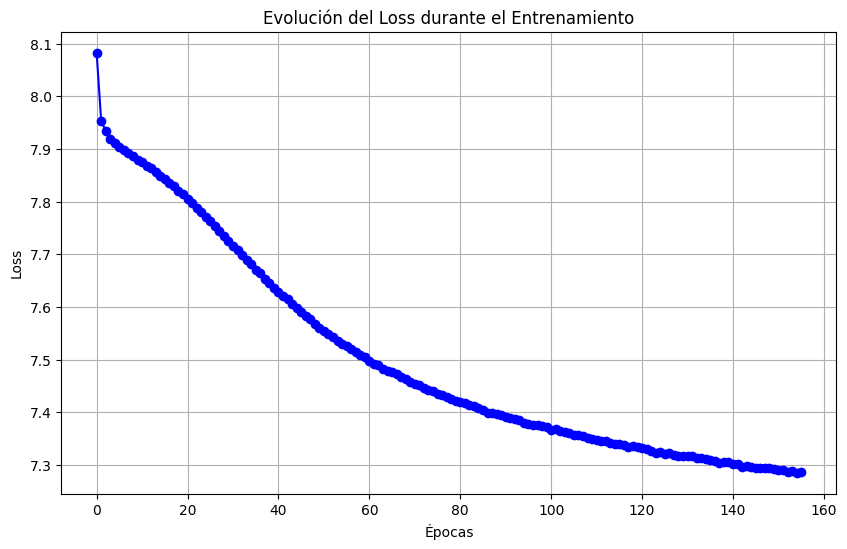

In [ ]:
# Graficar la evolución del loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(loss_history, marker='o', linestyle='-', color='b')
plt.title('Evolución del Loss durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


In [ ]:
import torch.nn.functional as F

# Evaluación y predicción de oraciones
model.eval()

# Parámetros de la evaluación
num_sentences = 10  # Número de oraciones a generar
num_words = 10      # Número de palabras por oración
temperature = [0.01, 1, 2]  # Temperatura para ajustar la aleatoriedad (Un valor de 1 es neutral, si se acerca a 0 el modelo se comporta similar a hacer un argmax en los logits)

print("Se ha agregado el concepto de 'temperatura' para ajustar el comportamiento del modelo durante la generación de texto.")
print("Una temperatura menor a 1 hace que el modelo se comporte de manera más conservadora, similar a aplicar argmax sobre los logits.")
print("Una temperatura igual a 1 representa un comportamiento neutro, utilizando la distribución original de probabilidades.")
print("Temperaturas mayores a 1 aumentan la aleatoriedad de las predicciones, permitiendo que el modelo explore más posibilidades.")

for temperature in temperature:
  print(f'\nTemperature: {temperature}')
  for i in range(num_sentences):
      predicted_sentence = []

      # Comienza con una palabra inicial y predice la siguiente en la secuencia
      current_word = random.choice(tokens)  # Escoge una palabra aleatoria para iniciar
      predicted_sentence.append(current_word)

      # Predice las siguientes palabras para formar una oración
      with torch.no_grad():
          for _ in range(num_words - 1):  # Ajustar para predicción de más palabras por oración
              input_idx = torch.tensor([ttoi[current_word]], dtype=torch.long).to(device)

              # Pasar la entrada por la capa de embeddings del modelo para obtener el vector de embeddings
              embedding = model.embedding(input_idx).unsqueeze(0).unsqueeze(0)  # Añadir batch y channel dimensions

              # Pasar el embedding por las capas convolucionales y fc manualmente
              x = embedding
              x = [torch.relu(conv(x)).squeeze(3) for conv in model.convs]  # Aplicar convoluciones
              x = [torch.max_pool1d(item, item.size(2)).squeeze(2) for item in x]  # Aplicar max pooling
              x = torch.cat(x, 1)  # Concatenar características
              x = model.dropout(x)
              output = model.fc(x)  # Capa completamente conectada

              # Aplicar temperatura a los logits
              adjusted_logits = output / temperature

              # Convertir los logits ajustados a probabilidades con softmax
              probabilities = F.softmax(adjusted_logits, dim=1)

              # Seleccionar la palabra basada en la distribución de probabilidades
              predicted_idx = torch.multinomial(probabilities, 1).item()
              predicted_word = itot[predicted_idx]

              # Añadir la palabra seleccionada a la oración
              predicted_sentence.append(predicted_word)
              current_word = predicted_word  # Actualiza la palabra actual para la siguiente predicción

      # Mostrar la oración generada
      print(f"Oración {i+1}: {' '.join(predicted_sentence)}")


Se ha agregado el concepto de 'temperatura' para ajustar el comportamiento del modelo durante la generación de texto.
Una temperatura menor a 1 hace que el modelo se comporte de manera más conservadora, similar a aplicar argmax sobre los logits.
Una temperatura igual a 1 representa un comportamiento neutro, utilizando la distribución original de probabilidades.
Temperaturas mayores a 1 aumentan la aleatoriedad de las predicciones, permitiendo que el modelo explore más posibilidades.

Temperature: 0.01
Oración 1: revolucionario aureliano buendía aureliano buendía aureliano buendía aureliano buendía aureliano
Oración 2: exterminados úrsula amaranta úrsula amaranta úrsula amaranta úrsula amaranta úrsula
Oración 3: macondo aureliano buendía aureliano buendía aureliano buendía aureliano buendía aureliano
Oración 4: tan tan tan tan aureliano segundo aureliano buendía aureliano buendía
Oración 5: dijo aureliano buendía aureliano buendía aureliano segundo aureliano buendía aureliano
Oración 6:

In [ ]:
import torch.nn.functional as F

# Función para obtener los vectores de embeddings de una palabra
def get_embedding_vector(word, model, ttoi, device):
    # Verificar si la palabra está en el vocabulario
    if word in ttoi:
        idx = torch.tensor([ttoi[word]], dtype=torch.long).to(device)
        with torch.no_grad():
            embedding_vector = model.embedding(idx).squeeze(0)
        return embedding_vector
    else:
        print(f"La palabra '{word}' no está en el vocabulario.")
        return None

# Función para calcular la similitud de coseno entre dos vectores
def cosine_similarity(vec1, vec2):
    return F.cosine_similarity(vec1.unsqueeze(0), vec2.unsqueeze(0)).item()

# Función para encontrar las palabras más similares
def find_most_similar_words(target_words, model, vocab, ttoi, itot, device, topn=10):
    # Obtener los embeddings de todas las palabras en el vocabulario
    all_embeddings = {word: get_embedding_vector(word, model, ttoi, device) for word in vocab}

    # Filtrar None (palabras no encontradas)
    all_embeddings = {word: vec for word, vec in all_embeddings.items() if vec is not None}

    for target_word in target_words:
        print(f"\nPalabras más similares a '{target_word}':")
        target_vector = get_embedding_vector(target_word, model, ttoi, device)

        if target_vector is not None:
            # Calcular similitud con todas las demás palabras
            similarities = {
                word: cosine_similarity(target_vector, vec) for word, vec in all_embeddings.items()
            }

            # Ordenar por similitud y seleccionar las más altas
            most_similar = sorted(similarities.items(), key=lambda item: item[1], reverse=True)[:topn]

            # Imprimir las palabras más similares
            for word, similarity in most_similar:
                print(f"  {word} (similaridad: {similarity:.4f})")
        else:
            print(f"La palabra '{target_word}' no está en el vocabulario o no se pudo procesar.")

# Lista de palabras objetivo
target_words = ['aureliano', 'coronel', 'macondo', 'casa', 'pueblo', 'melquíades', 'arcadio', 'úrsula']

# Llamar a la función para encontrar las palabras más similares
find_most_similar_words(target_words, model, vocab, ttoi, itot, device, topn=10)



Palabras más similares a 'aureliano':
  aureliano (similaridad: 1.0000)
  tenebrosa (similaridad: 0.5377)
  edad (similaridad: 0.5191)
  ponerles (similaridad: 0.5038)
  chimenea (similaridad: 0.4730)
  dicción (similaridad: 0.4688)
  traje (similaridad: 0.4663)
  trasponer (similaridad: 0.4492)
  eternizada (similaridad: 0.4348)
  intenciones (similaridad: 0.4309)

Palabras más similares a 'coronel':
  coronel (similaridad: 1.0000)
  sitio (similaridad: 0.5671)
  malo (similaridad: 0.5000)
  rieles (similaridad: 0.4975)
  castaño (similaridad: 0.4688)
  espejismo (similaridad: 0.4572)
  prudencio (similaridad: 0.4564)
  sabe (similaridad: 0.4278)
  fruto (similaridad: 0.4212)
  zapatillas (similaridad: 0.4162)

Palabras más similares a 'macondo':
  macondo (similaridad: 1.0000)
  custodiada (similaridad: 0.5898)
  descrito (similaridad: 0.4806)
  ofreció (similaridad: 0.4707)
  posterior (similaridad: 0.4605)
  vivir (similaridad: 0.4550)
  funda (similaridad: 0.4536)
  beso (similar

# Resultados

El modelo mantiene valores similares de pérdida durante el entrenamiento, sin embargo, durantevarias pruebas se puedo observar como al cambiar el numero de capas y parámetros de la cnn se podía conseguir mejores valores de perdida.
Por otro lado , el entrenamiento de la capa de embeddings devuelve resultados similares al ejercicio realizado anterioremen y durante las pruebas de generación de oraciones se mantienen resultados con oraciones que usan pocos concetores entre ideas y no tine una consistencia de genero y singular o plurar de palabras .